# Temperature Profile Classification - 2 Class system
GMM classification of Southern Ocean Argo float temperature profile data. This notebook looks at automatic generation for PCA N values, with 2 classes.<br><br>
### Dask import

<br>

### Choices for data

In [59]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskUKESM"
dataFileName = "GMMSampleDataUK1L.npy"
sampleFileName = "GMMSampleTimeGeoUK1.npy"
scalerName = "GMMScalerUK1L.bin"
modelName = "GMMUK2Class1"

#Data definitions
lastESMDecade = slice('2005-01','2014-12')
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
runIdSel = 0

#Custom GMM variables
pcaThreshold = 0.98
pcaNControl = 3 #set to int value to select, otherwise pcaThreshold is used to automatically assign value
firstBicLoopControl = 10 #number of times bic value is calculated for each number of classes
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [3]:
sampleDataLabelled = np.load(dataFileName)
sampleDepthAxis = sampleDataLabelled[0]
sampleData = sampleDataLabelled[1:]

sampleTimeGeo = np.load(sampleFileName, allow_pickle=True)
print("Sample data loaded into sampleData.\nSample time geo data loaded into sampleTimeGeo.")

Sample data loaded into sampleData.
Sample time geo data loaded into sampleTimeGeo.


<br>
<b>Loading ocean Mask</b>

In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Combining sample data and sample time/geo data</b>

In [5]:
metaData = {"Lat":sampleTimeGeo[0], "Lon":sampleTimeGeo[1], "Time":sampleTimeGeo[2]}
sampleMetaDF = pd.DataFrame(metaData, columns=["Lat", "Lon", "Time"])
sampleDataDF = pd.DataFrame(sampleData, columns=sampleDepthAxis)
sampleDF = pd.concat([sampleMetaDF,sampleDataDF], axis=1)
sampleDF["Time"] = pd.to_datetime(sampleDF["Time"])
print("SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.")

SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.


<br>
<b>Loading UKESM data</b>

In [60]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No UKESM data sets opened")
    
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets
print("Data sets successfully merged")

dfESMLat = fileSet.thetao.where(fileSet.latitude < maxLat, drop=True) #Selection of latitude
dfESMLat = dfESMLat.rename({"latitude":"lat", "longitude":"lon"})
dfESMLatLev = dfESMLat.sel(lev=levSel) #Selects level data down to 2k
dfESMLatLevT = dfESMLatLev.sel(time=lastESMDecade)
#dfESMLatLevTR = dfESMLatLevT.sel(RunId = runIdSel)
#dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("UKESM data sucessfully loaded into dfESMLatLevT.")

3 UKESM1-0-LL data sets opened
Data sets successfully merged
UKESM data sucessfully loaded into dfESMLatLevT.


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
<li>loadModel - loadeds and returns GMM model named in input.
</ul>

In [6]:
def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> bicPlot - Plots BIC score array against component number.
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
<li> tempPointPlot - Plots the temperature profile of a single point against depth.
<li> tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [7]:
def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    bicArrayMin = np.min(bicArray)
    bicRange = bicArrayMax-bicArrayMin
    if bicRange == 0:
        bicRange = 20 #provides border 1 if all bic values are identical
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([bicArrayMin-0.05*bicRange, bicArrayMax+0.05*bicRange])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)
    
    
def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")
    

def locationPlotGroupDF(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["Lon"], dataFrame["Lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["Time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["Lon"], timeData["Lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")
    
    
def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
    
def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["Lon"], dataFrame["Lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["Time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["Lon"], timeData["Lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")
    
    
def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()

    
def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0])[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)'''

print("Plotting functions defined.")

Plotting functions defined.


<br>

### Scaling
<b>Scaling Implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [8]:
scalerLoad = load(scalerName)
sampleDataScaled = scalerLoad.transform(sampleData)
print("Scaling of sampleData complete, stored in sampleDataScaled.")

Scaling of sampleData complete, stored in sampleDataScaled.


<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

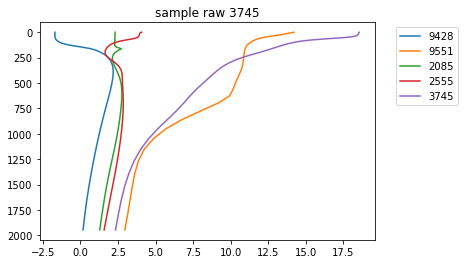

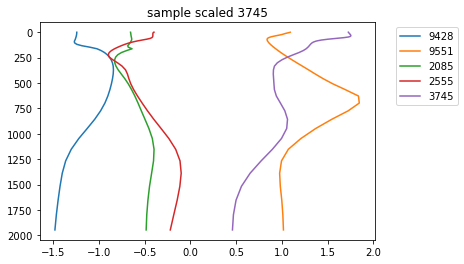

In [9]:
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(10000)
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*2*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*2*i+1)

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [10]:
pca = PCA(n_components=pcaNControl) #initialising PCA 
pca.fit(sampleDataScaled) #fitting model to data
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### Model Import
The GMM calculated in the v1.3 notebook is here imported.

In [11]:
bestGMModel = loadModel(modelName)
bicMin = bestGMModel.bic(sampleDataScaledPCA)
bicComponentMin = bestGMModel.n_components
componentNo = bicComponentMin
print("Model "+modelName+" loaded. The bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")

Model GMMUK2Class1 loaded. The bicScore was 130901.79 for 2.


<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [12]:
labels = bestGMModel.predict(sampleDataScaledPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs

try:
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

Labels identified for model (2 components) and added to sampleDF with associated probability.


<br>

### Calculating properties of profiles based on class assignment

In [13]:
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sort the labels based on mean near-surface temperatures

In [14]:
surfaceMeans = sampleDFMeans[sampleDepthAxis[0]].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))

try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [15]:
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print("Number of samples in each group calculated and stored in profileCount.")

sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).
Number of samples in each group calculated and stored in profileCount.


<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [16]:
print(sampleDFSortMeans[sampleDataDF.columns[0]])

labelSorted
0     1.598772
1    13.139378
Name: 0.5057600140571594, dtype: float64


<br>

### Plotting the means and standard deviations of the classes by profile

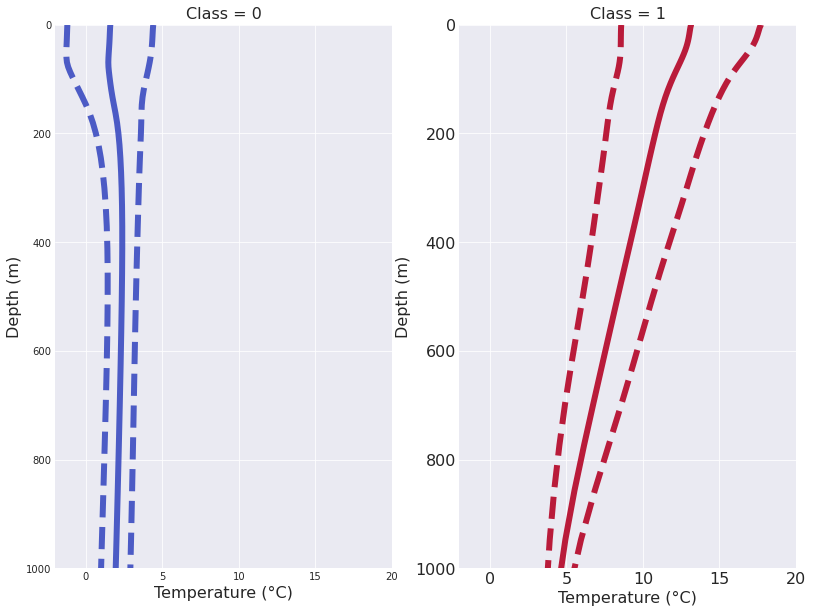

In [17]:
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

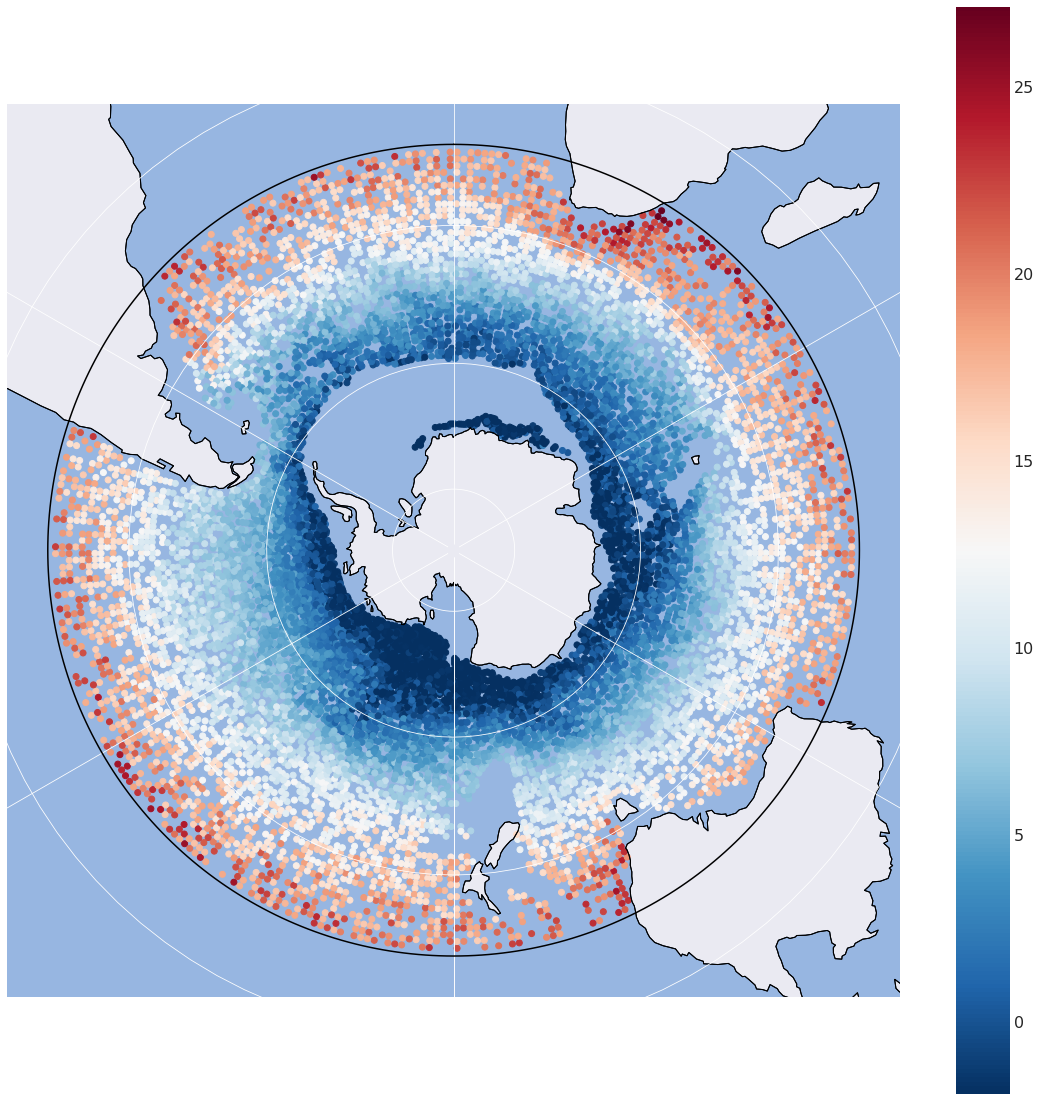

In [18]:
plt.figure(1, figsize=(20,20))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.coastlines()
ax.gridlines()
#im = ax.scatter(sampleDF["Lon"], sampleDF["Lat"], transform=ccrs.PlateCarree(), c =  sampleDF["labelSorted"], cmap='RdBu_r')
im = ax.scatter(sampleDF["Lon"], sampleDF["Lat"], transform=ccrs.PlateCarree(), c =  sampleDF[0.5057600140571594], cmap='RdBu_r')
cb = plt.colorbar(im)
plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
plt.show()

In [19]:
sampleLabelData = np.array(sampleDF["labelSorted"])
sampleMetaData = np.append(sampleTimeGeo, [sampleLabelData], axis = 0)
print("Sorted label added to sampleMetaData")

Sorted label added to sampleMetaData


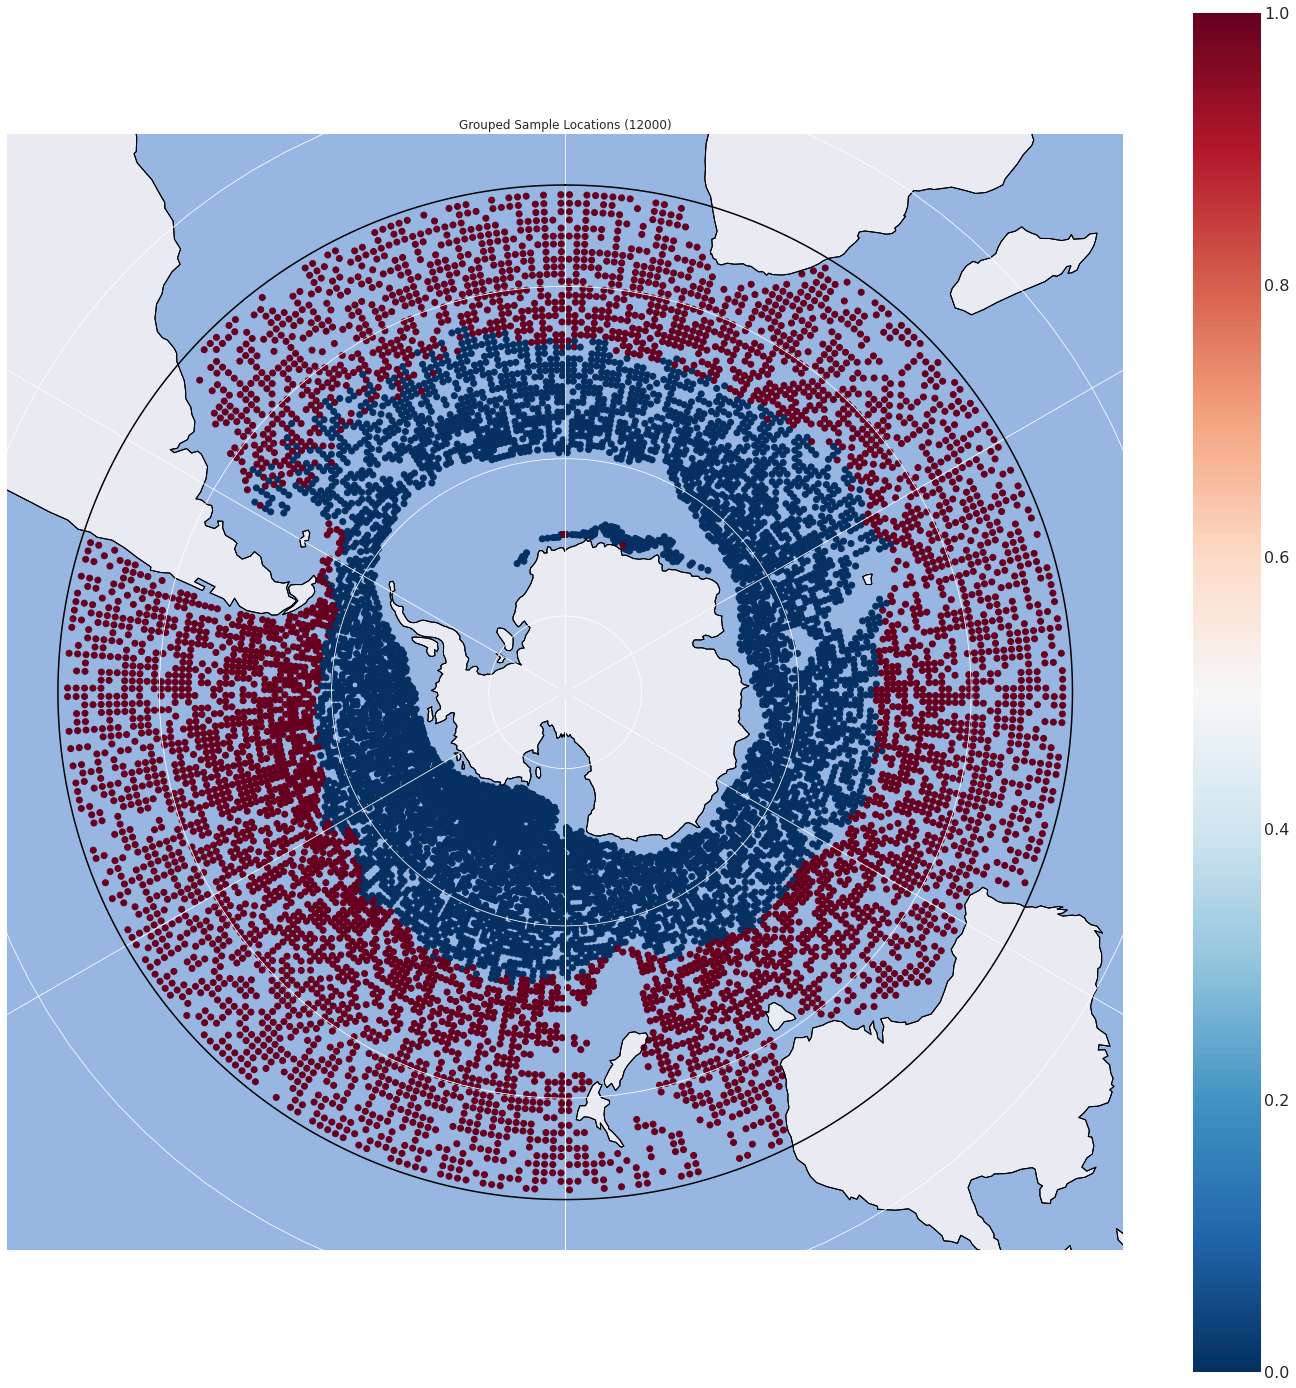

In [20]:
locationPlotGroup(sampleMetaData, (25,25), 1)

Classifications, grouped by month.


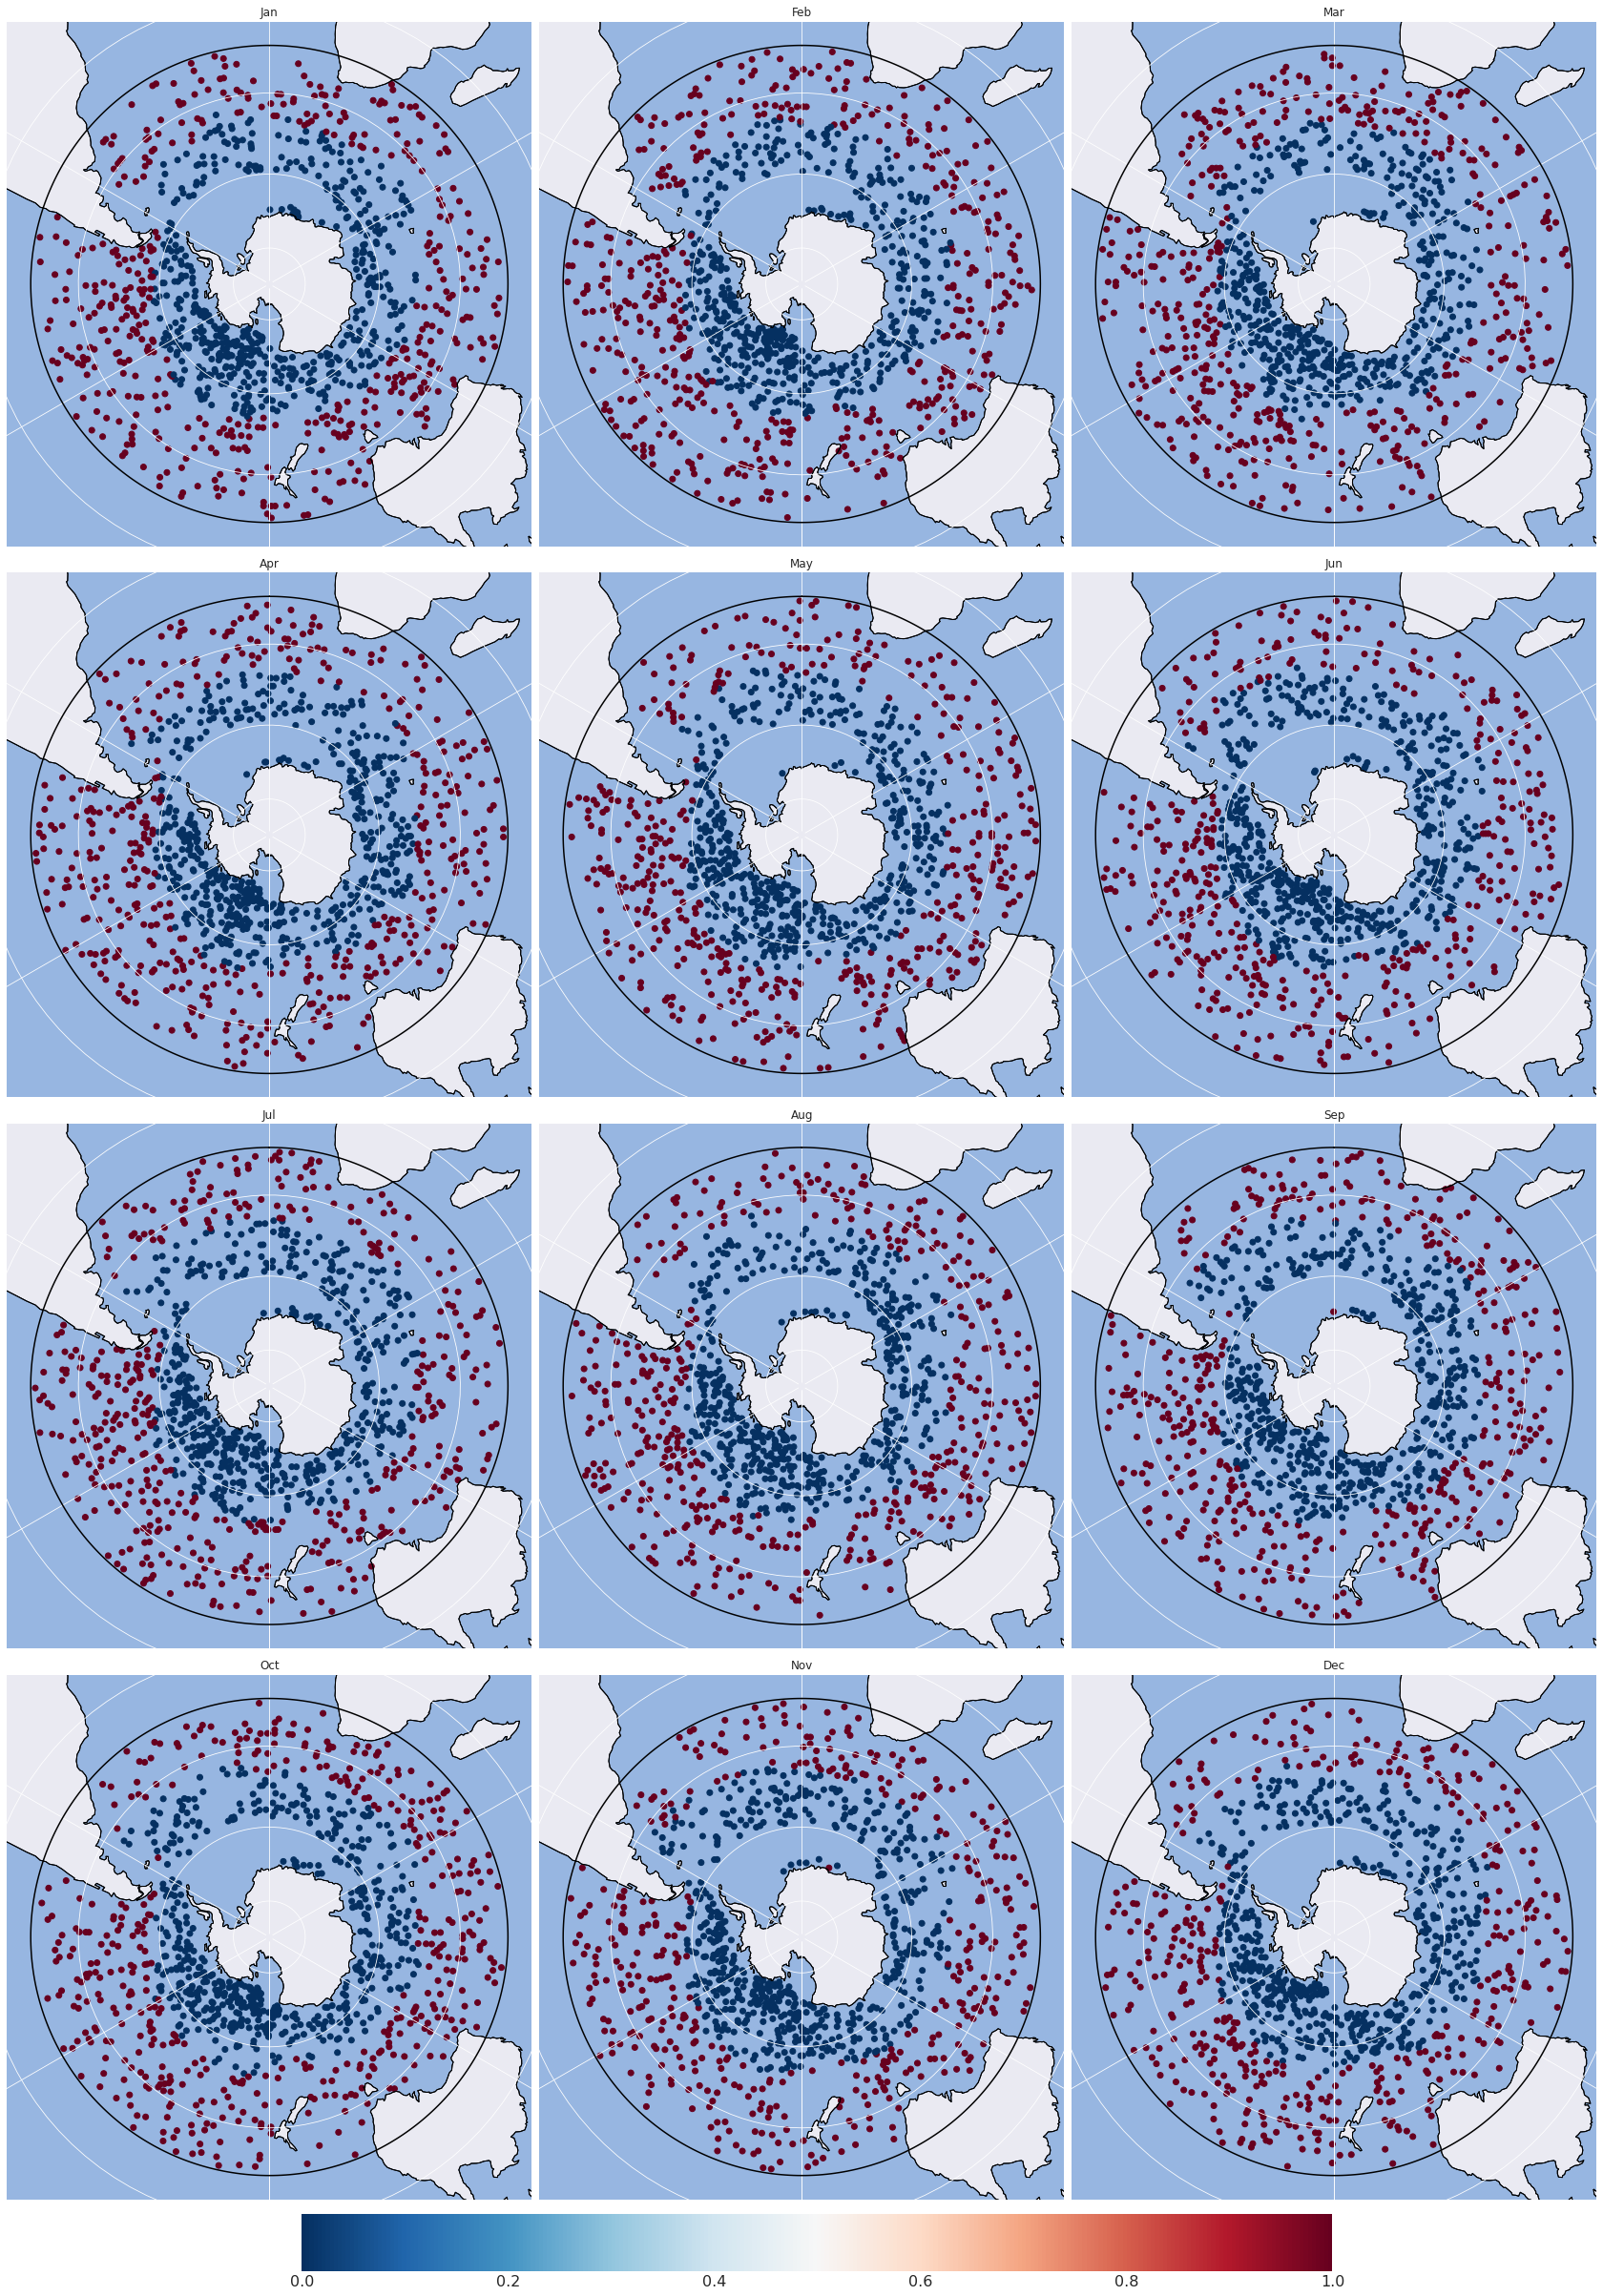

In [21]:
locationPlotGroupDFMonthly(sampleDF, "Monthly summaries for training data set", 1)
print("Classifications, grouped by month.")

Uncertainty in classifications, grouped by month.


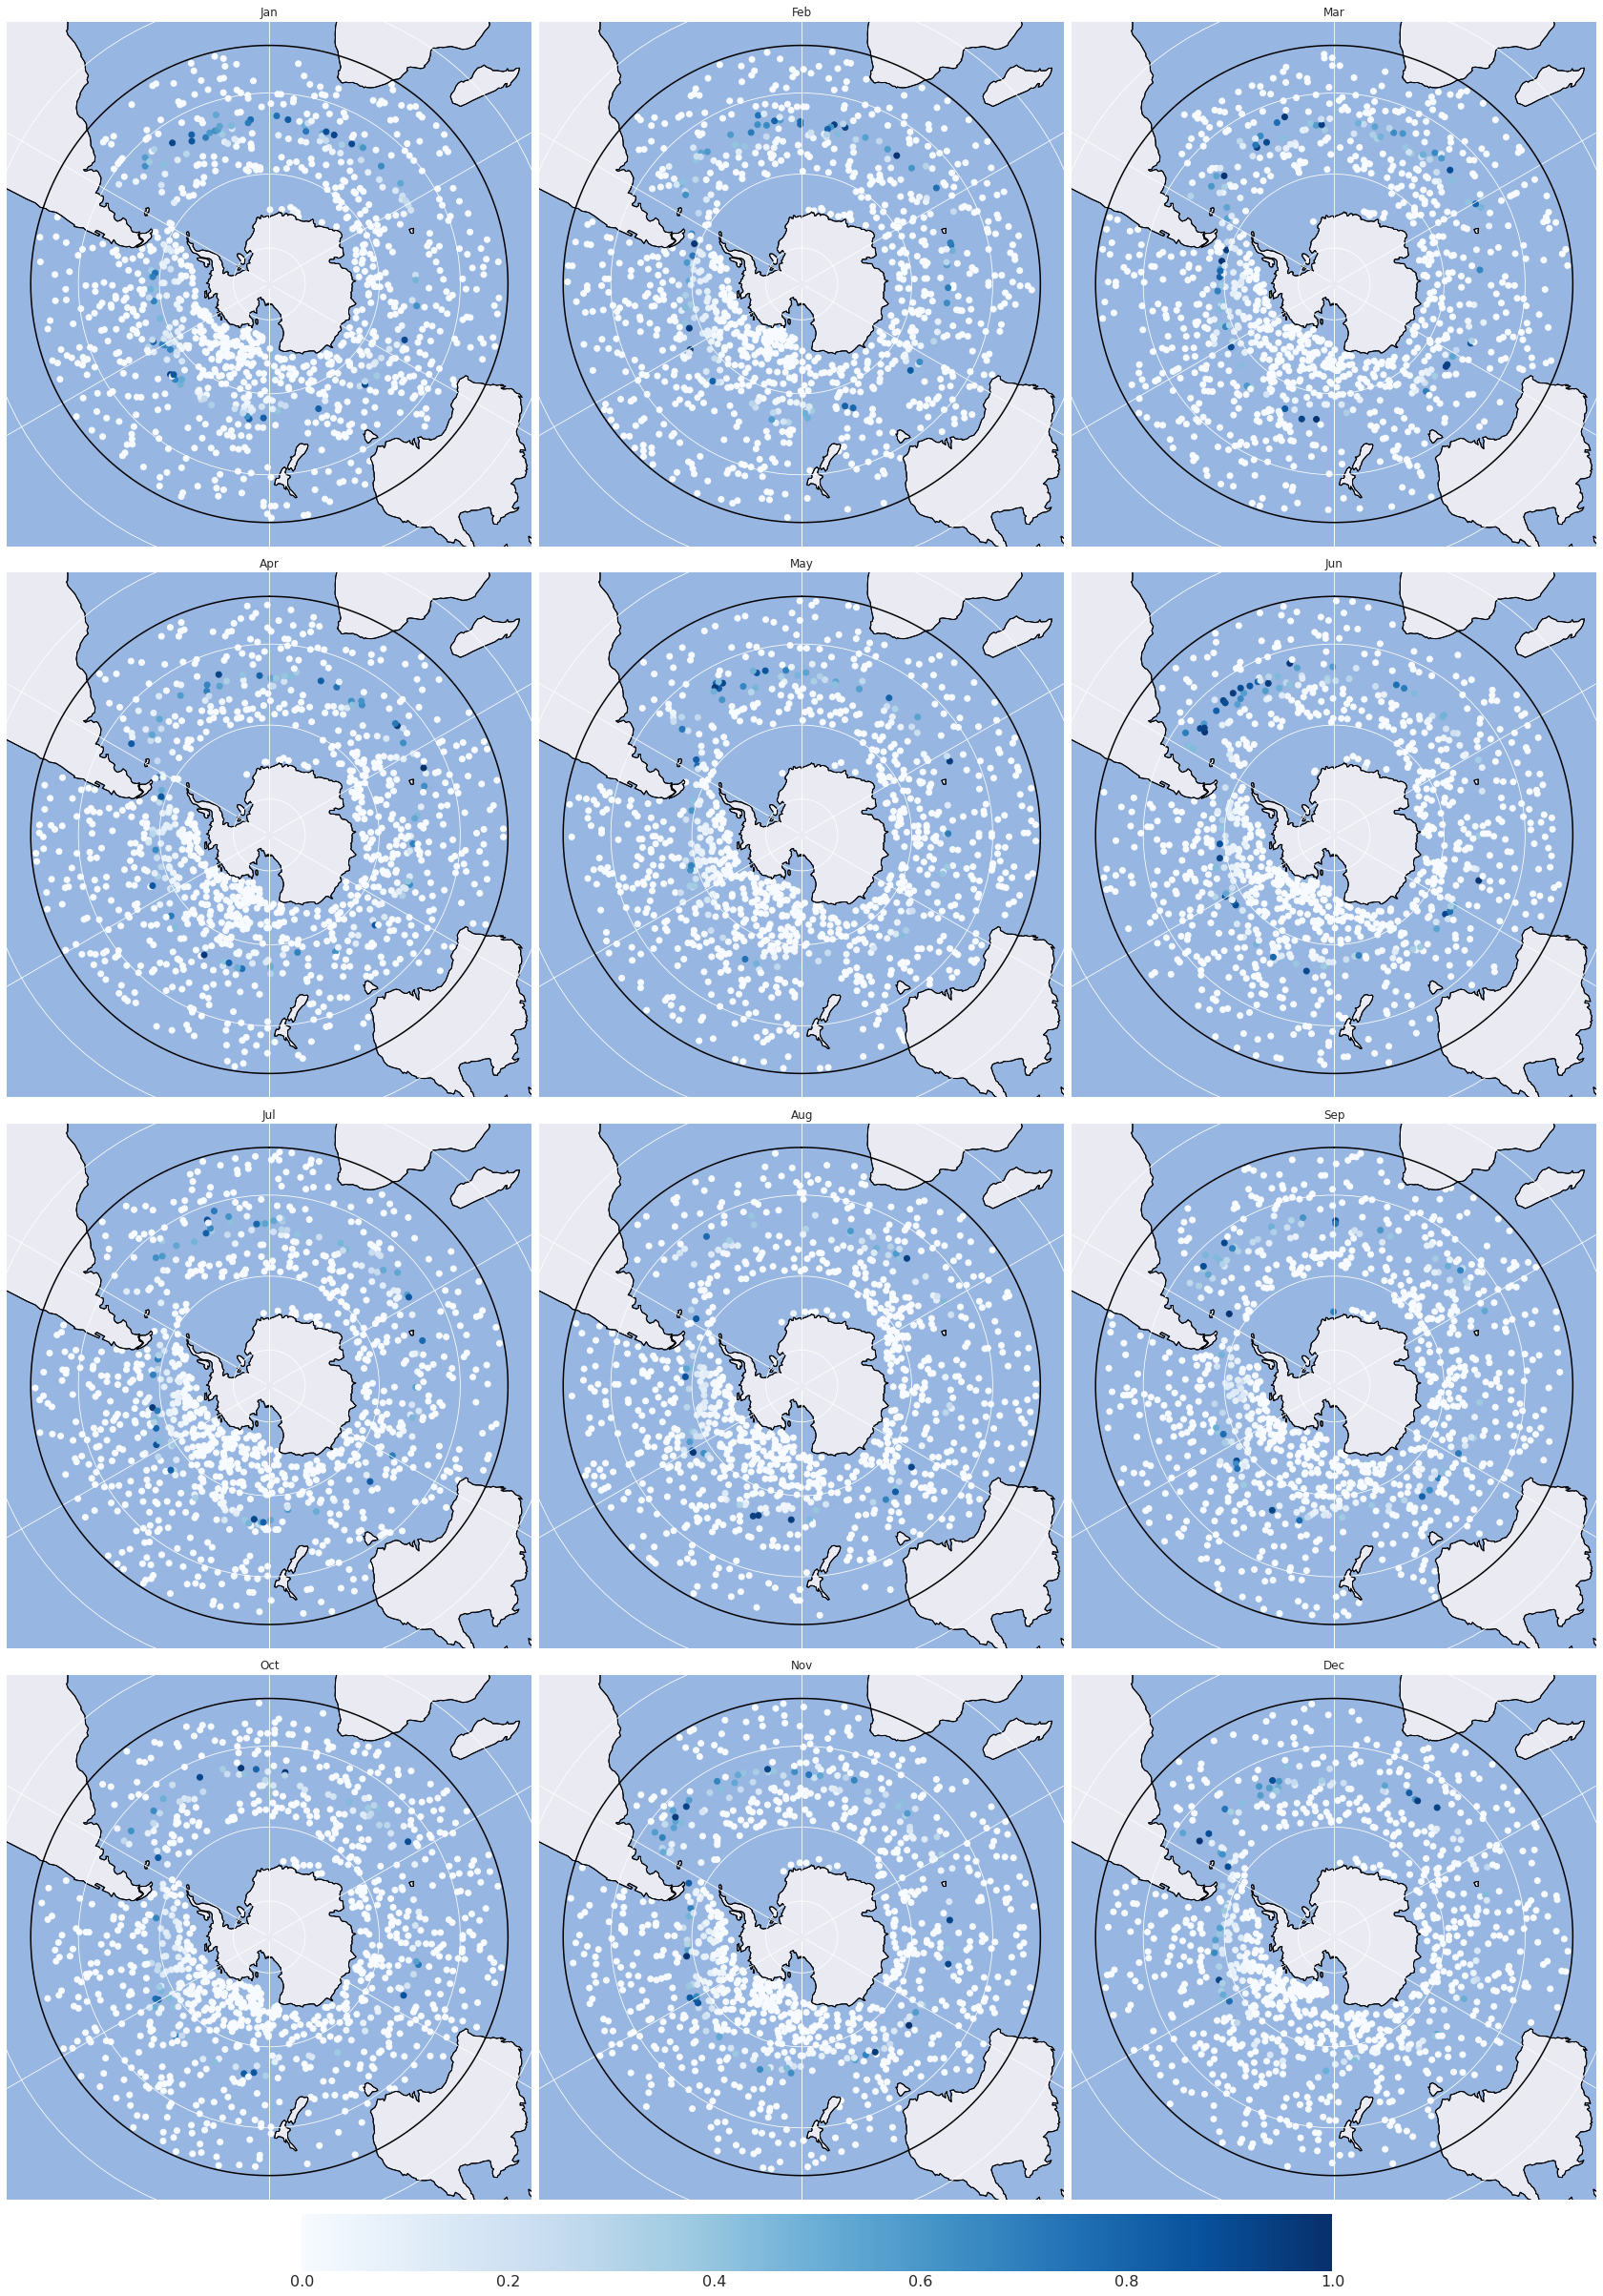

In [22]:
locationPlotUncertaintyDFMonthly(sampleDF, "Monthly uncertainty", 1)
print("Uncertainty in classifications, grouped by month.")

In [49]:
x = sampleDF[(sampleDF["labelSorted"]==1) & (sampleDF["Lat"]<-60)]
x

Lat        Lon       Time  label  max posterior prob  \
11661 -69.487289  -0.498792 2014-09-01      0            0.649870   
11818 -69.482681  21.500662 2014-11-01      0            0.951968   

       labelSorted  classUncertainty  0.5057600140571594  1.5558552742004395  \
11661            1          0.700261           -1.910213           -1.910187   
11818            1          0.096064           -1.885267           -1.885203   

       2.6676816940307617  ...  856.678955078125  947.4478759765625  \
11661           -1.910166  ...         -0.103419           0.139119   
11818           -1.885546  ...          0.328003           0.505015   

       1045.854248046875  1151.9912109375  1265.8614501953125  1387.376953125  \
11661           0.313892         0.410453            0.443894        0.437021   
11818           0.600785         0.633567            0.616221        0.561862   

       1516.3636474609375  1652.5684814453125  1795.6707763671875  \
11661            0.394252            0.307827            0.190734   
11818            0.475294            0.362946            0.235699   

       1945.2955322265625  
11661            0.079469  
11818            0.108680  

[2 rows x 61 columns]

In [106]:
date = "2014-09"
i=0

singleMonth = dfESMLatLev.sel(time=date, RunId = i)
singleMonthSurface = singleMonth.sel(lev=singleMonth["lev"].values[0])
singleMonthSurface

<xarray.DataArray 'thetao' (time: 1, j: 139, i: 360)>
dask.array<getitem, shape=(1, 139, 360), dtype=float32, chunksize=(1, 139, 360), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137 138
    lat      (j, i) float32 dask.array<chunksize=(139, 360), meta=np.ndarray>
    lev      float64 0.5058
    lon      (j, i) float32 dask.array<chunksize=(139, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 2014-09-01
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        mo: This variable is reported using a z* coordinate syste...
    long_name:      Sea Water Potential Temperature
    original_name:  mo: (variable_name: thetao)
    standard_name:  sea_water_potential_temperature
    units:          degC

In [ ]:
singleMonthScaled = scalerLoad.transform(singleMonth.values)
singleMonthScaledPCA = pca.transform(singleMonthScaled)
labels = bestGMModel.predict(singleMonthScaledPCA) #assignment of class labels from best GMM
posteriorProbs = bestGMModel.predict_proba(singleMonthScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs #2 class I factor

try:
    monthDF = monthDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
monthDF.insert(3, "label", labels, True)
monthDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
monthDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

In [113]:
#singleMonthStack = singleMonth.stack(geo=(singleMonth.lat,singleMonth.lon))
singleMonthStack = singleMonth.stack(ij=('i','j'))
singleMonthStack = singleMonthStack.squeeze()
#apply mask
singleMonthStack

<xarray.DataArray 'thetao' (lev: 54, ij: 50040)>
dask.array<getitem, shape=(54, 50040), dtype=float32, chunksize=(54, 50040), chunktype=numpy.ndarray>
Coordinates:
    lat      (ij) float32 dask.array<chunksize=(50040,), meta=np.ndarray>
  * lev      (lev) float64 0.5058 1.556 2.668 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (ij) float32 dask.array<chunksize=(50040,), meta=np.ndarray>
    time     datetime64[ns] 2014-09-01
  * ij       (ij) MultiIndex
  - i        (ij) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359
  - j        (ij) int64 0 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137 138
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        mo: This variable is reported using a z* coordinate syste...
    long_name:      Sea Water Potential Temperature
    original_name:  mo: (variable_name: thetao)
    standard_name:  sea_water_potential_temperature
    units:          degC

In [115]:
singleMonthScaled = scalerLoad.transform(singleMonthStack.T)
singleMonthScaledPCA = pca.transform(singleMonthScaled)
labels = bestGMModel.predict(singleMonthScaledPCA) #assignment of class labels from best GMM
posteriorProbs = bestGMModel.predict_proba(singleMonthScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs #2 class I factor

try:
    monthDF = monthDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
monthDF.insert(3, "label", labels, True)
monthDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
monthDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').